In [90]:
from pathlib import Path
import pandas as pd
import numpy as np
from import_clean_data import load_annotated_meter_data, load_co2_data, load_filtered_meter_data
import warnings
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
import seaborn as sb

In [2]:
DATA_DIR = (Path.cwd() / ".." / "Data").resolve()

In [3]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    co2 = load_co2_data(DATA_DIR)

In [4]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    df = load_filtered_meter_data(DATA_DIR)

In [5]:
epoch = pd.to_datetime(0, utc=True)
neutral_epoch = pd.to_datetime(0)

def to_unix_timestamp(x):
    return (x - epoch).total_seconds()

def to_unix_timestamp_neutral(x):
    return (x - neutral_epoch).total_seconds()

In [6]:
df.dtypes

id                              int64
Chargepoint                    object
connector                      object
charge_log_id                  object
metervalue                      int64
increment                       int64
timestamp              datetime64[ns]
unique_charge_point            object
n_timestamp                   float64
co2_intensity                 float64
co2_total                     float64
dtype: object

In [47]:
class Calculator:
    def __init__(self, co2):
        self.co2 = co2
        self.co2_arr = self.get_quarterly_co2_array(self.co2)
        self.co2_start, self.co2_end = to_unix_timestamp(co2['datetime'].min()), to_unix_timestamp(co2['datetime'].max())
        
    def get_quarterly_co2_array(self, df):
        func = interp1d(np.arange(0, len(df) * 4, 4), df["co2_intensity"], kind="linear")
        xs = np.arange(len(df) * 4 - 4)
        return func(xs)
    
    def __call__(self, cycle):
        if ((to_unix_timestamp_neutral(cycle['timestamp'].min()) < self.co2_start) or 
            (to_unix_timestamp_neutral(cycle['timestamp'].max()) > self.co2_end)):
            raise ValueError
        
        index = self.get_index_in_co2_array(cycle['timestamp'].min())
        charge = self.get_charge_cycle_as_array(cycle)
        current = cycle['co2_total'].sum()
        min_, max_ =  self.get_possibilities_for_cycle(self.co2_arr[index: index + len(cycle)], charge)
        return min_, max_, current
        
    def get_possibilities_for_cycle(self, co2, charge):
        last_start = len(co2) - len(charge)
        slc = len(charge)
        possibilities = [(co2[x: x + len(charge)] * charge).sum() / 4 for x in range(last_start)]
        return min(possibilities), max(possibilities)

    def get_index_in_co2_array(self, dt):
        # Get results in seconds
        normalized = to_unix_timestamp_neutral(dt.round('15min'))
        # Offset is the difference in number of seconds to the start of the CO2 array
        # converted to 15 minute intervals
        return int(round(normalized - self.co2_start) / 60 / 15)
    
    def get_charge_cycle_as_array(self, df):
        # Ignores zeros at start and end
        # Also convert Wh to kWh, g CO2 to kg
        return np.trim_zeros(df['increment'].to_numpy()) / 1000 / 1000
        

In [100]:
class LookAheadCalculator(Calculator):
    def get_index_in_co2_array(self, dt):
        return super().get_index_in_co2_array(dt) + (4 * 12)


In [48]:
calc = Calculator(co2)

In [55]:
len(df['charge_log_id'].unique())

13067

In [ ]:
results = np.zeros((len(df['charge_log_id'].unique()), 3))

In [95]:
results = np.load(DATA_DIR / "optimal_same_cycle_results.npy")

In [76]:
for i, charge_id in enumerate(df['charge_log_id'].unique()):
    try:
        results[i, :] = calc(df[df['charge_log_id'] == charge_id])
    except ValueError:
        continue
    if not i % 500:
        print(i)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000


In [95]:
np.save(DATA_DIR / "optimal_same_cycle_results.npy", results, allow_pickle=False)

In [103]:
la_calc = LookAheadCalculator(co2)

In [104]:
results_la = np.zeros((len(df['charge_log_id'].unique()), 3))

In [105]:
for i, charge_id in enumerate(df['charge_log_id'].unique()):
    try:
        results_la[i, :] = la_calc(df[df['charge_log_id'] == charge_id])
    except ValueError:
        continue
    if not i % 500:
        print(i)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8500
9000
9500
10000
10500
11500


In [109]:
np.save(DATA_DIR / "optimal_look_ahead_results.npy", results_la, allow_pickle=False)

In [115]:
mask = (results[:, 0] != 0) * (results[:, 2] != 0)
mask2 = ((results[mask, 0] / results[mask, 2]) < 1)

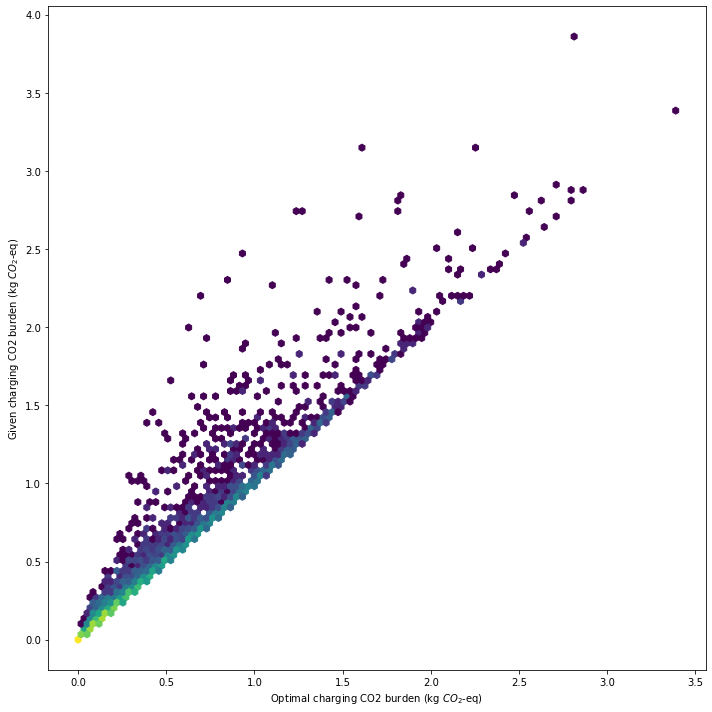

In [96]:
plt.figure(figsize=(10, 10))
plt.hexbin(results[mask, 0][mask2], results[mask, 2][mask2], mincnt=1, bins='log')
plt.xlabel(r"Optimal charging CO2 burden (kg $CO_{2}$-eq)")
plt.ylabel(r"Given charging CO2 burden (kg $CO_{2}$-eq)")
plt.tight_layout()
plt.savefig(DATA_DIR / ".." / "Images" / "Hexbin given versus optimal charging same period.png", dpi=300)

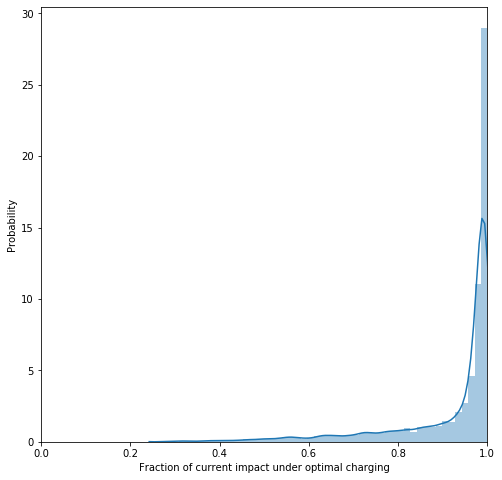

In [116]:
ratio = results[mask, 0][mask2] / results[mask, 2][mask2]

plt.figure(figsize=(8, 8))
sb.distplot(ratio)
plt.xlim(0, 1)
plt.xlabel("Fraction of current impact under optimal charging")
plt.ylabel("Probability")
plt.savefig(DATA_DIR / ".." / "Images" / "Hist of current cycle optimized CO2 burden.png", dpi=300)

In [120]:
results[mask, 0][mask2].sum() / results[mask, 2][mask2].sum()

0.8846972593433439

In [118]:
mask = (results_la[:, 0] != 0) * (results_la[:, 2] != 0)
mask2 = ((results_la[mask, 0] / results_la[mask, 2]) < 1)

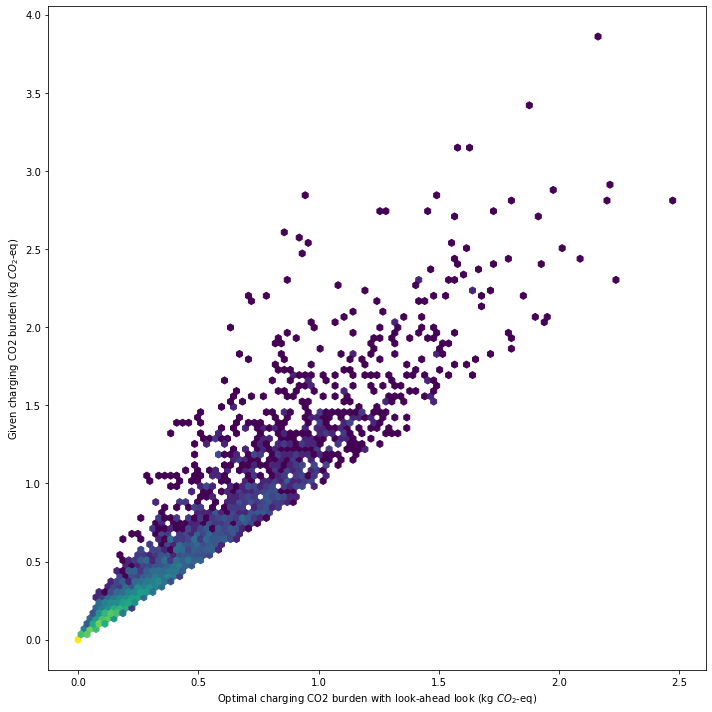

In [107]:
plt.figure(figsize=(10, 10))
plt.hexbin(results_la[mask, 0][mask2], results_la[mask, 2][mask2], mincnt=1, bins='log')
plt.xlabel(r"Optimal charging CO2 burden with look-ahead look (kg $CO_{2}$-eq)")
plt.ylabel(r"Given charging CO2 burden (kg $CO_{2}$-eq)")
plt.tight_layout()
plt.savefig(DATA_DIR / ".." / "Images" / "Hexbin given versus look ahead charging same period.png", dpi=300)

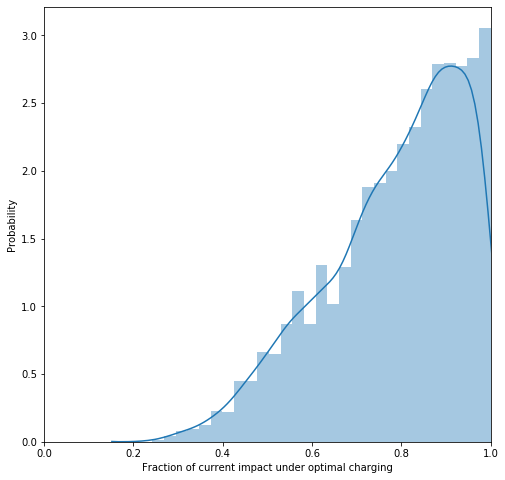

In [114]:
ratio = results_la[mask, 0][mask2] / results_la[mask, 2][mask2]

plt.figure(figsize=(8, 8))
sb.distplot(ratio)
plt.xlim(0, 1)
plt.xlabel("Fraction of current impact under optimal charging")
plt.ylabel("Probability")
plt.savefig(DATA_DIR / ".." / "Images" / "Hist of look ahead CO2 burden.png", dpi=300)

In [121]:
results_la[mask, 0][mask2].sum() / results_la[mask, 2][mask2].sum()

0.7418872322503263